# Dimension Expansion

This notebook is about dimension expansion, the fact that the Koopman operator is infinite-dimensoinal, even for systems that have finite dimension. We'll use the 1-D Ornstein-Uhlenbeck process as our example for this part of the notebook, because its Koopman eigenfunctions are known analyitcally.

In [43]:
import numpy as np
import torch


# LANGEVIN DYNAMICS

def vvel_lng_batch(x, v, a, drag, T, dt, nsteps):
    """ Langevin dynamics with Velocity-Verlet.
    Batched version: compute multiple trajectories in parallel
    This function mutates the position (x) and velocity(v) arrays.
    Compute nsteps updates of the system: We're passed x(t=0) and v(t=0) and
    return x(dt*nsteps), v(dt*nsteps). Leapfrog updates are used for the intermediate steps.
    a(x) is the acceleration as a function of the position.
    drag[] is a vector of drag coefficients to be applied to the system.
    T is the temperature in units of energy.
    dt is the timestep size.
    Shapes:
    x: (batch, coorddim)
    v: (batch, coorddim)
    drag: (coorddim,)
    a: (-1, coorddim) -> (-1, coorddim)
    return = x:(batch, coorddim), v:(batch, coorddim)"""
    assert nsteps >= 1
    assert x.shape == v.shape and drag.shape == x.shape[1:]
    noise_coeffs = np.sqrt(2*drag*T*dt) # noise coefficients for a dt timestep
    def randn():
        return np.random.randn(*x.shape)
    v += 0.5*(dt*(a(x) - drag*v) + np.sqrt(0.5)*noise_coeffs*randn())
    for i in range(nsteps - 1):
        x += dt*v
        v += dt*(a(x) - drag*v) + noise_coeffs*randn()
    x += dt*v
    v += 0.5*(dt*(a(x) - drag*v) + np.sqrt(0.5)*noise_coeffs*randn())
    return x, v


class TrajectorySim:
    def __init__(self, acc_fn, drag, T, delta_t, t_res):
        """ Object representing a physical system for which we can generate trajectories.
        acc_fn : function defining the system, gives acceleration given position
        drag : vector of drag coefficients, also gives the shape of the position vector
        T : temperature
        delta_t : time spacing at which we take samples
        t_res : time resolution, number of individual simulation steps per delta_t """
        self.acc_fn = acc_fn
        self.drag = drag
        self.T = T
        self.delta_t = delta_t
        self.t_res = t_res
        self.dt = delta_t/t_res
        self.dim = drag.flatten().shape[0]
    def generate_trajectory(self, batch, N, initial_x=None, initial_v=None):
        x_traj = np.zeros((batch, N, self.dim))
        v_traj = np.zeros((batch, N, self.dim))
        if initial_x is None: initial_x = np.zeros((batch,) + self.drag.shape)
        if initial_v is None: initial_v = np.zeros((batch,) + self.drag.shape)
        x = initial_x.copy()
        v = initial_v.copy()
        for i in range(N):
            vvel_lng_batch(x, v, self.acc_fn, self.drag, self.T, self.dt, self.t_res)
            x_traj[:, i] = x
            v_traj[:, i] = v
        return x_traj, v_traj


sims = {
    "1D Ornstein Uhlenbeck": TrajectorySim(
        (lambda x: -x),
        np.array([10.]), 1.0,
        3.0, 60
    ),
}

def get_ou_eigen_1d():
  sim = sims["1D Ornstein Uhlenbeck"]
  return np.exp(-sim.delta_t/sim.drag[0])

# DATASET GENERATION
def get_dataset(sim, N, L, device="cpu"):
    dataset = np.zeros((N, L, sim.dim)) # just training on position coordinates for now. training on velocity too makes dim twice as large
    t_eql = 120 # number of delta_t to wait to system to equilibriate, data before this point is thrown away
    x_traj, _ = sim.generate_trajectory(N, L+t_eql)
    dataset = x_traj[:, t_eql:]
    return torch.tensor(dataset, dtype=torch.float32, device=device)


In [37]:
# Koopman eigenfunctions are Hermite polynomials

hermites = torch.tensor([
    [1., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0.],
    [-1., 0., 1., 0., 0.],
    [0., -3., 0., 1., 0.],
    [3., 0., -6., 0., 1.],
])
scalings = torch.exp(-0.5*torch.lgamma(1 + torch.arange(hermites.shape[0])))
hermites = hermites * scalings[:, None]
def poly_eval(x, poly):
    deg = len(poly)
    powers = x[:, None] ** torch.arange(deg)[None, :]
    return (poly*powers).sum(-1)



In [7]:
# 1D HARMONIC DATASET
print("generating 1d dataset...")
dataset_1d = get_dataset(sims["1D Ornstein Uhlenbeck"], 10000, 100)
print("done.")

generating 1d dataset...
done.


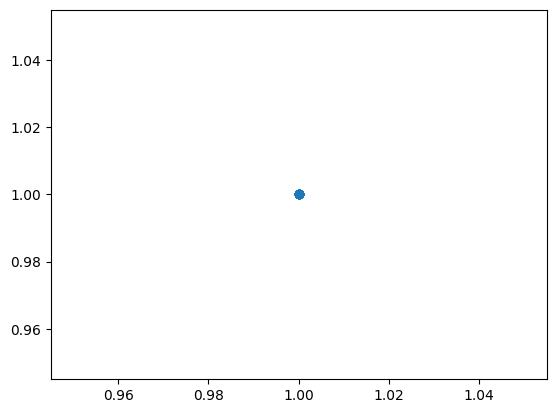

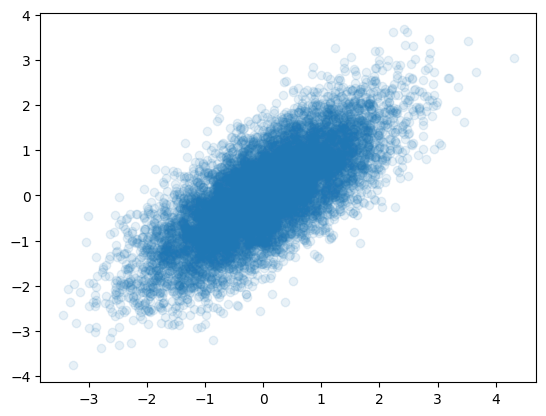

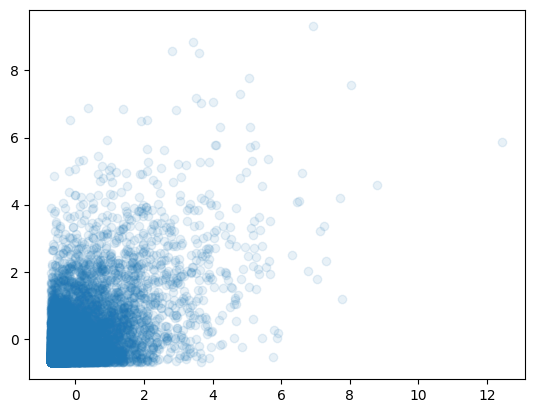

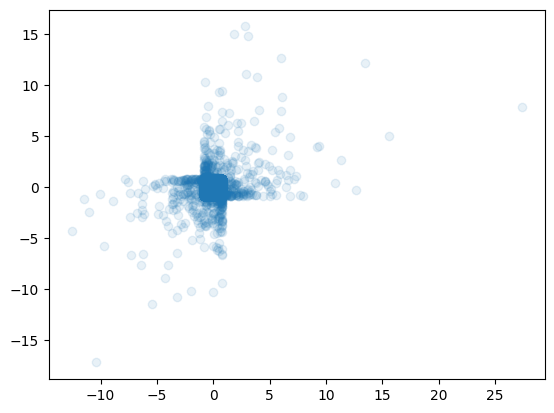

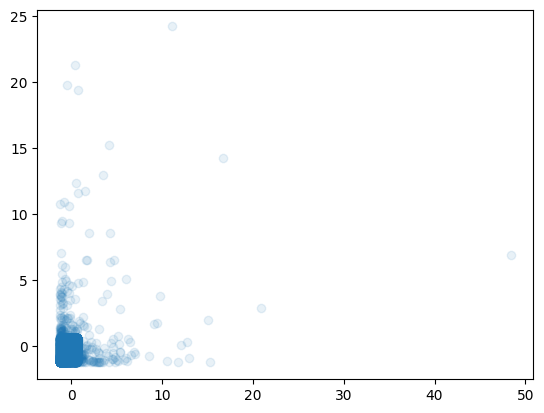

In [72]:
# DIMENSION EXPANSION PLOTTING

import matplotlib.pyplot as plt

N, L, _ = dataset_1d.shape

x0 = dataset_1d[:, -2].reshape(N, 1)
x1 = dataset_1d[:, -1].reshape(N, 1)

for i in range(5):
    plt.scatter(poly_eval(x0, hermites[i]), poly_eval(x1, hermites[i]), alpha=0.1)
    plt.show()


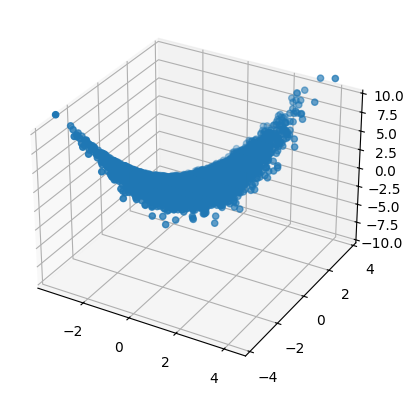

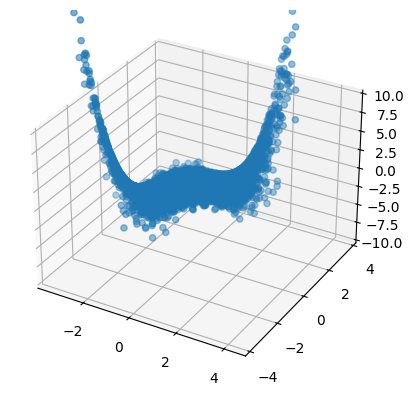

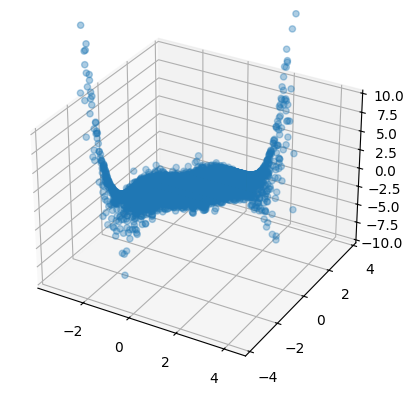

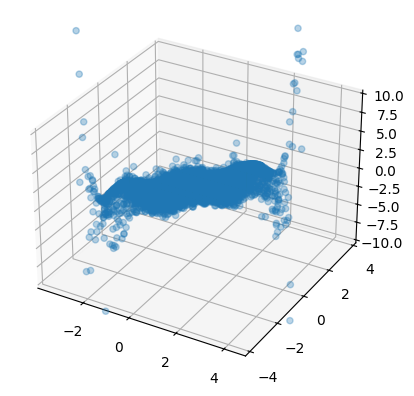

In [73]:

for i in range(1, 5):
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(x0, x1, poly_eval(x0, hermites[i])*poly_eval(x1, hermites[i]))
    ax.set_zlim(-10., 10.)
    plt.show()


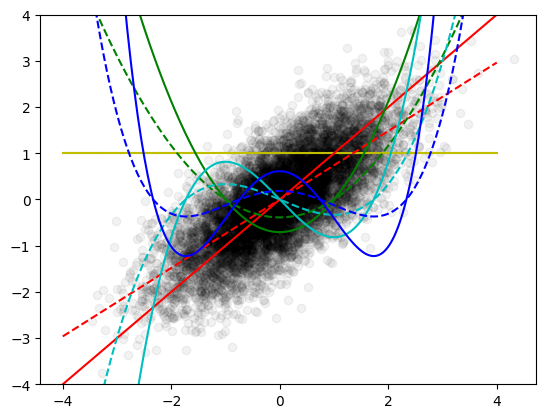

In [74]:

x = torch.linspace(-4., 4., 256)
eigenvalues = np.exp(torch.arange(5)*np.log(get_ou_eigen_1d()))
plt.scatter(x0, x1, color='k', alpha=0.05)
line_colors = ['y', 'r', 'g', 'c', 'b']
for i in range(5):
    plt.plot(x, poly_eval(x, hermites[i]), color=line_colors[i])
    plt.plot(x, eigenvalues[i]*poly_eval(x, hermites[i]), linestyle="--", color=line_colors[i])
plt.ylim(-4, 4)
plt.show()


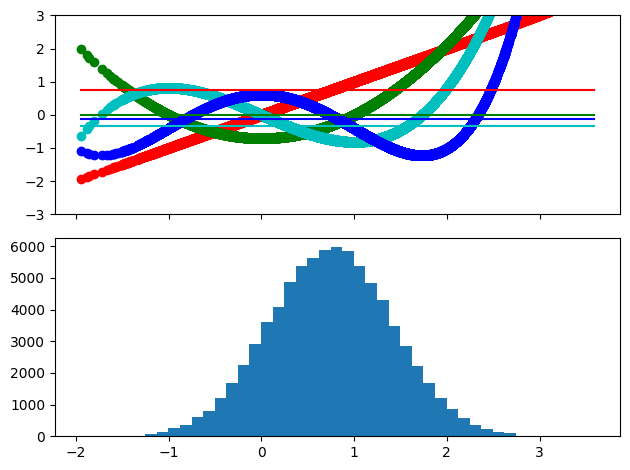

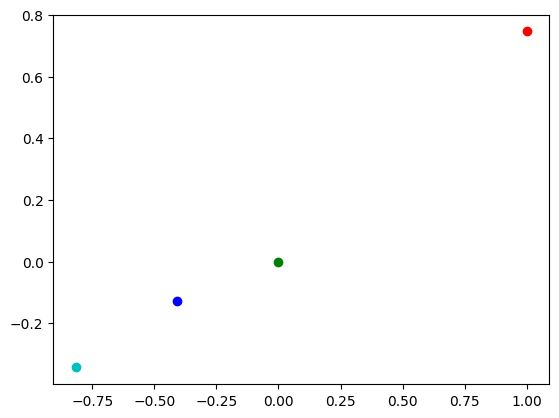

In [83]:
# plot starting from one point:

x0 = 1.0
x1, v1 = sims["1D Ornstein Uhlenbeck"].generate_trajectory(80000, 1, x0+np.zeros((80000, 1)), np.zeros((80000, 1)))
x1 = x1[:, 0]

fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True)
for i in range(1, 5):
    H_i = poly_eval(torch.tensor(x1), hermites[i])
    axs[0].scatter(x1, H_i, color=line_colors[i])
    axs[0].plot([x1.min(), x1.max()], [H_i.mean(), H_i.mean()], color=line_colors[i])
axs[0].set_ylim(-3, 3)
axs[1].hist(x1, bins=32, range=[x1.mean() - 2, x1.mean() + 2.])
plt.show()

for i in range(1, 5):
    plt.scatter(poly_eval(torch.tensor([x0]), hermites[i]), poly_eval(torch.tensor(x1), hermites[i]).mean(), color=line_colors[i])
plt.show()


